In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
! kaggle datasets download -d mrsimple07/laptoppriceprediction
! tar -xf laptoppriceprediction.zip


  0%|          | 0.00/39.1k [00:00<?, ?B/s]
100%|██████████| 39.1k/39.1k [00:00<00:00, 576kB/s]


In [11]:
data = pd.read_csv("Laptop_price.csv")

### Data analysis

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brand             1000 non-null   object 
 1   Processor_Speed   1000 non-null   float64
 2   RAM_Size          1000 non-null   int64  
 3   Storage_Capacity  1000 non-null   int64  
 4   Screen_Size       1000 non-null   float64
 5   Weight            1000 non-null   float64
 6   Price             1000 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 54.8+ KB


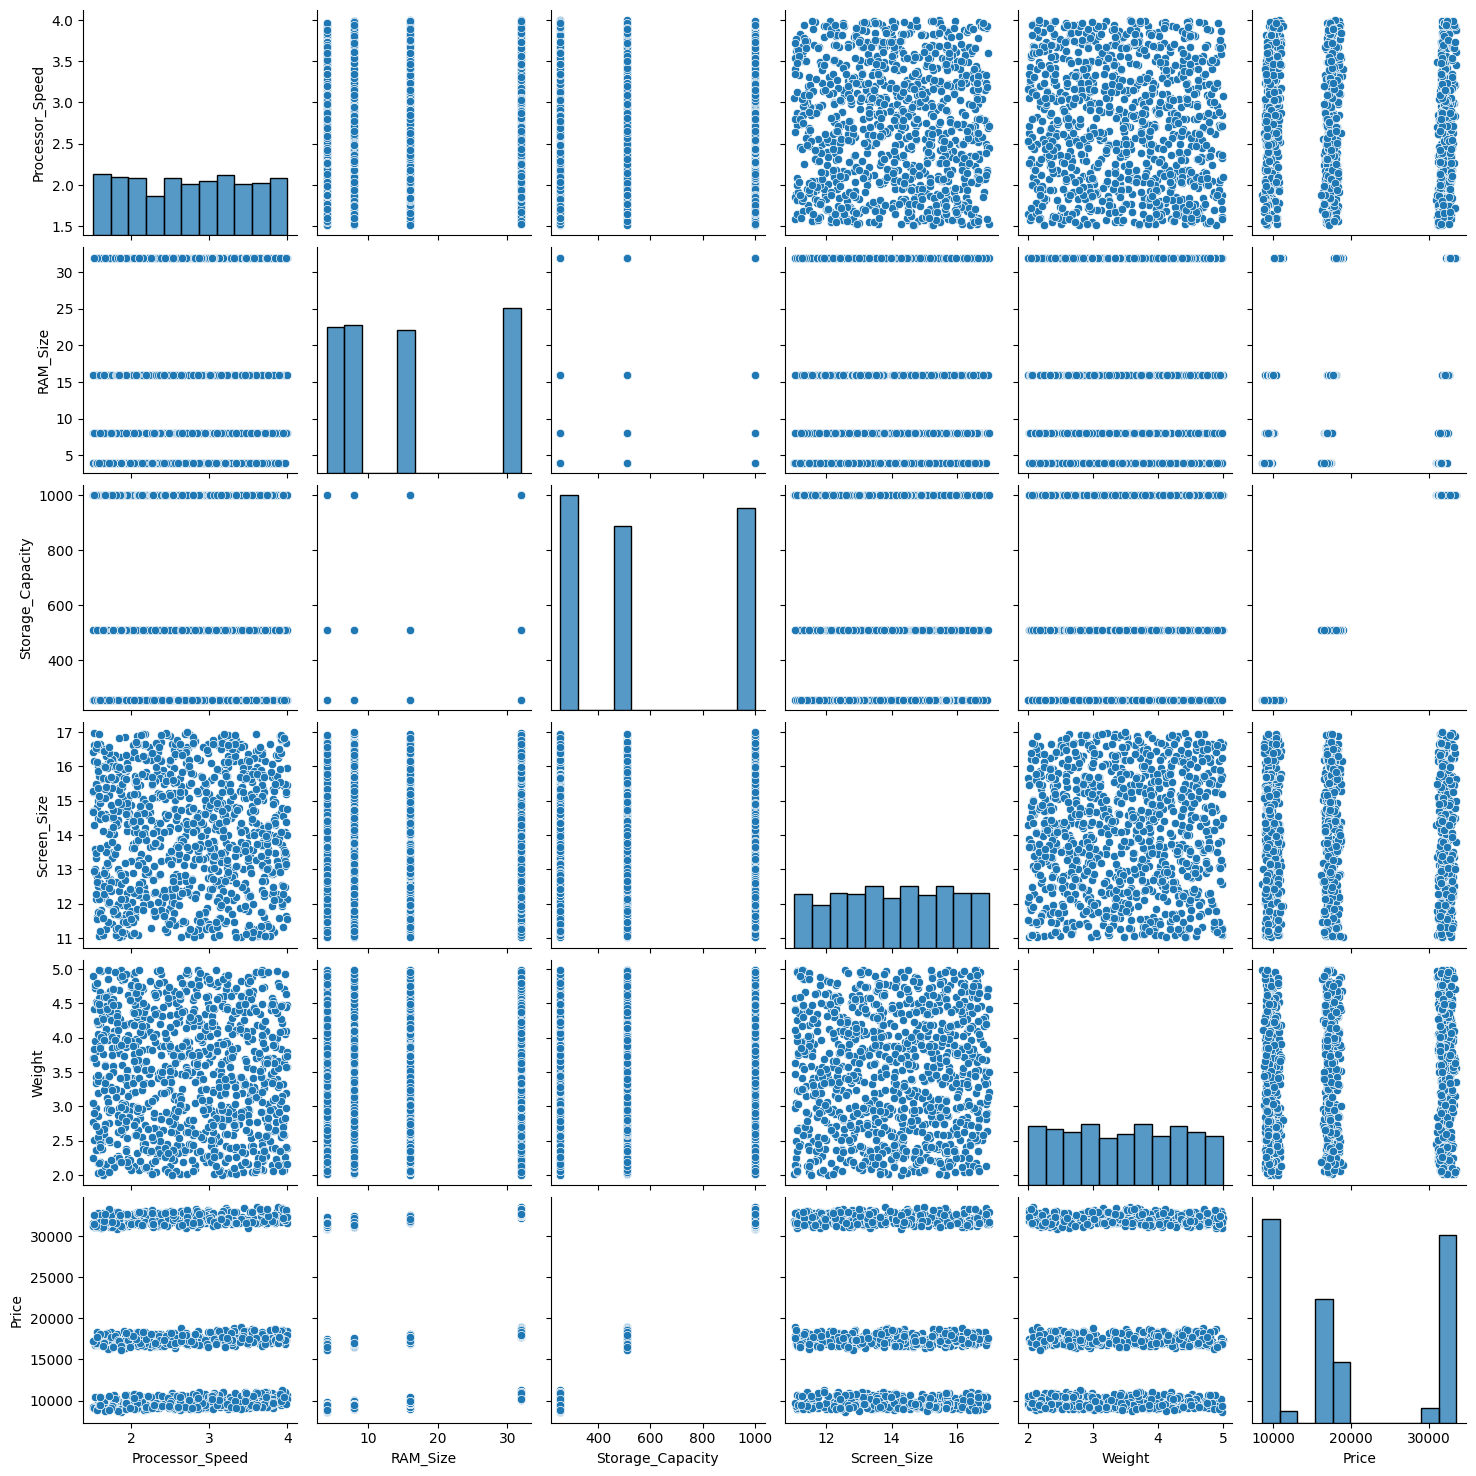

In [36]:
sns.pairplot(data)

In [4]:
num_cols = data.select_dtypes([np.number]).columns
cat_cols = data.select_dtypes(object).columns

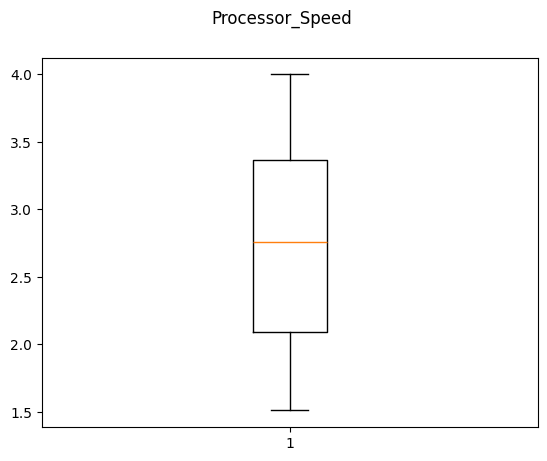

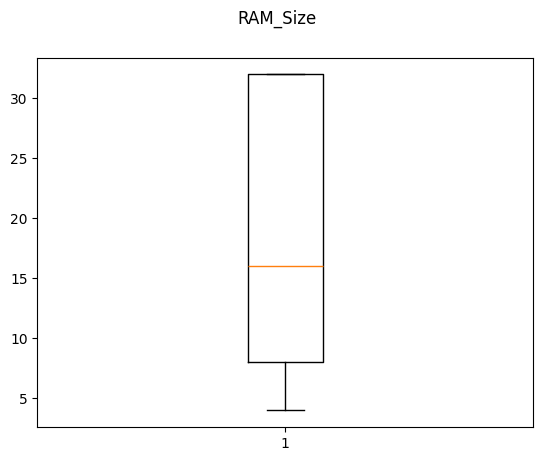

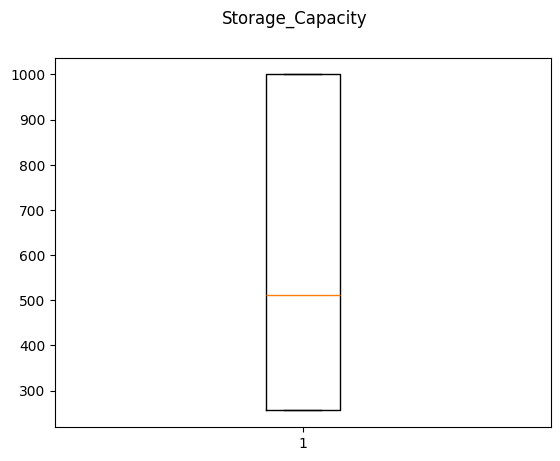

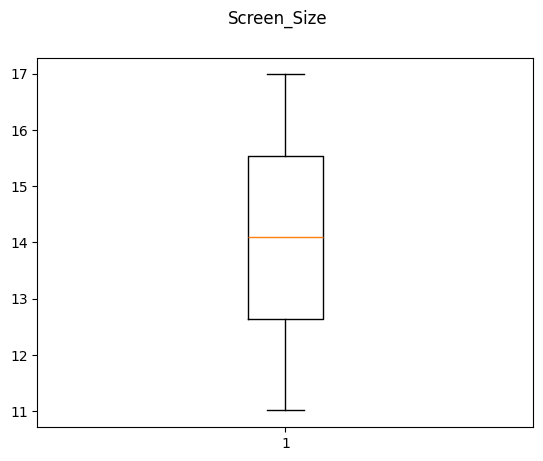

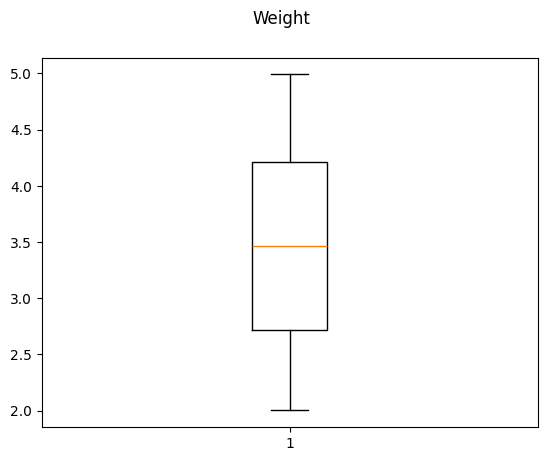

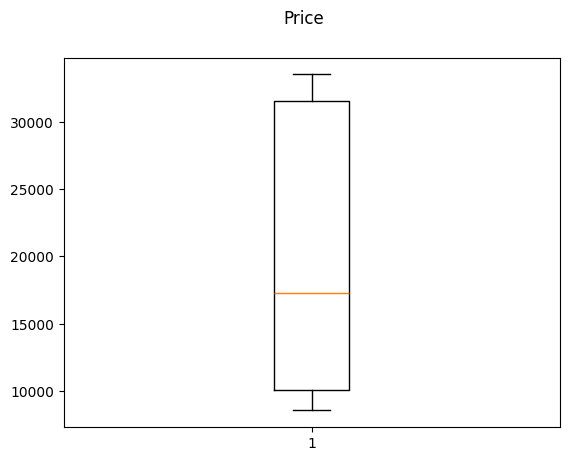

In [75]:
for i in num_cols:
    plt.suptitle(i)
    plt.boxplot(x = data[i])
    plt.show()

<Axes: xlabel='Brand', ylabel='count'>

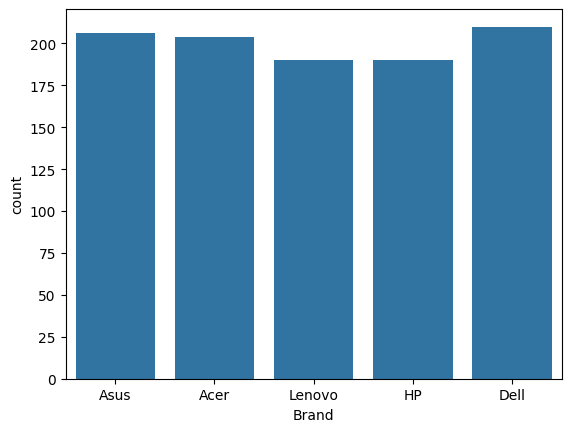

In [82]:
sns.countplot(data=data, x = data['Brand'])

<Axes: xlabel='Price'>

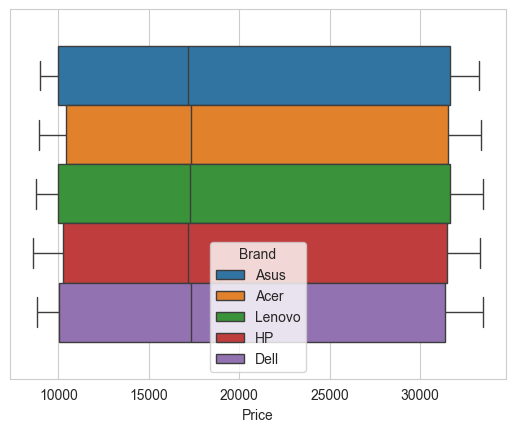

In [92]:
sns.boxplot(x = data['Price'],hue = data['Brand'])

<Axes: >

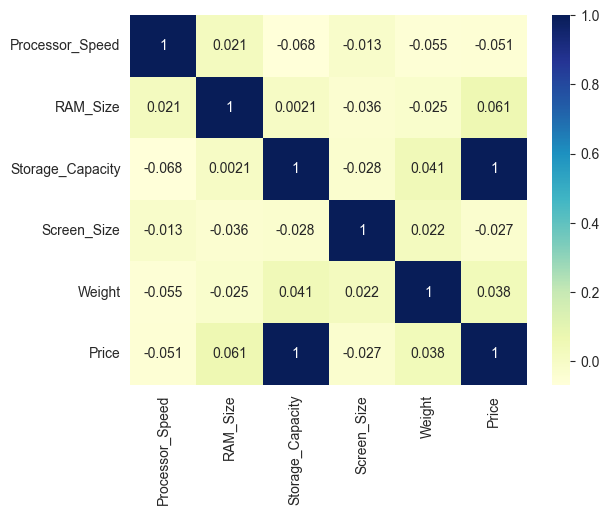

In [220]:
sns.heatmap(data[num_cols].corr(), cmap="YlGnBu", annot=True)

In [232]:
data['Processor_Speed'].shape[0]

1000

In [240]:
def covar(x, y):
    return (np.sum(np.multiply(x - x.mean(), y - y.mean())) / (x.shape[0]-1))
def standard_deviation(x):
    return np.sqrt(np.sum((x - x.mean())**2) / x.shape[0])
def corr(x, y):
    return (covar(x,y) / (standard_deviation(x)*standard_deviation(y)))

In [243]:
corr(data['Weight'], data['Price'])

0.03841662982443304

In [264]:
def corr_mat(X):
    corr_dict = {}
    for i in X.columns:
        corr_dict[i] = []
        for j in X.columns:
            corr_dict[i].append(corr(X[i], X[j]))
    return pd.DataFrame(corr_dict, columns=X.columns, index=X.columns)

In [265]:
corr_mat(data[num_cols])

,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price
Processor_Speed,1.000000,0.021391,-0.067576,-0.013425,-0.054603,-0.050737
RAM_Size,0.021391,1.000000,0.002111,-0.036002,-0.025382,0.061237
Storage_Capacity,-0.067576,0.002111,1.000000,-0.027560,0.041335,0.997908
Screen_Size,-0.013425,-0.036002,-0.027560,1.000000,0.021995,-0.026740
Weight,-0.054603,-0.025382,0.041335,0.021995,1.000000,0.038417
Price,-0.050737,0.061237,0.997908,-0.026740,0.038417,1.000000


<Axes: >

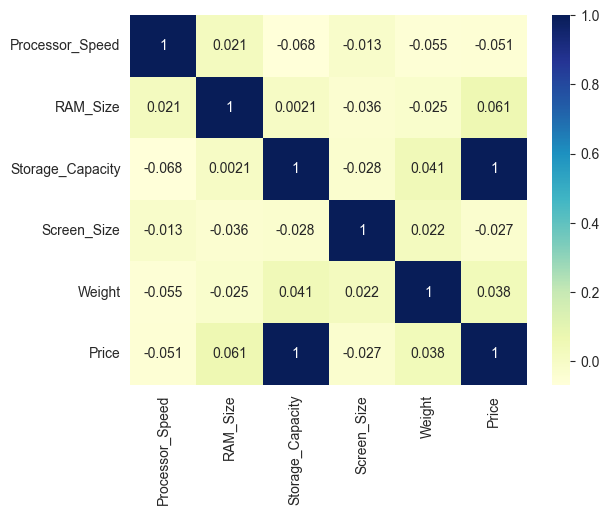

In [266]:
sns.heatmap(corr_mat(data[num_cols]), cmap="YlGnBu", annot=True)

### Preprocessing

In [111]:
data = data.drop_duplicates()

In [112]:
data[num_cols] = data[num_cols].fillna(data[num_cols].mean())

In [132]:
for i in num_cols:
    data = data[(data[i] > data[i].quantile(.001)) & (data[i] < data[i].quantile(.999))]

<Axes: xlabel='Price', ylabel='Count'>

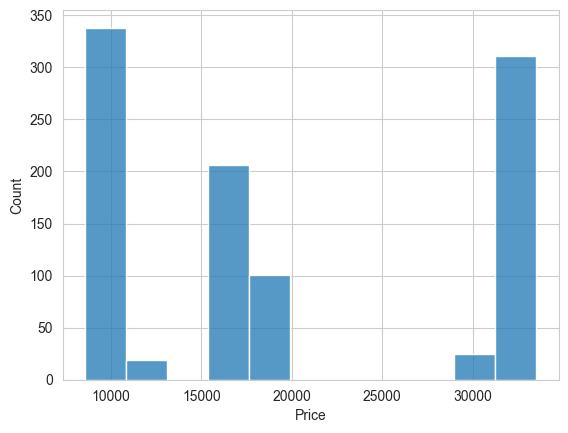

In [136]:
sns.histplot(data = data, x = data['Price'])

In [12]:
data['Price'] = pd.cut(data['Price'], bins = [0, 20000, 30000, 35000], labels = ['cheap', 'medium', 'expensive'])

In [7]:
data.sample(5)

,Brand,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price
890,HP,3.806893,8,1000,16.069174,4.487452,expensive
65,Asus,2.633222,32,1000,11.432667,2.423323,expensive
470,HP,2.481234,32,256,13.414010,3.852587,cheap
273,Asus,2.218097,32,1000,12.866015,3.011909,expensive
272,Dell,2.386555,32,512,12.271366,4.311342,medium


In [16]:
X = data.drop('Price', axis = 1)
y = data['Price']

In [71]:
from info_gain import info_gain
for i in X.columns:
    print(i, info_gain.info_gain(y, data[i]))

Brand 0.004673306949545042
Processor_Speed 1.0967119966298997
RAM_Size 0.003165814701890257
Storage_Capacity 1.0967119966298997
Screen_Size 1.0967119966298997
Weight 1.0967119966298997


In [8]:
for i in X.columns:
    print(i, data[i].unique().shape)

Brand (5,)
Processor_Speed (1000,)
RAM_Size (4,)
Storage_Capacity (3,)
Screen_Size (1000,)
Weight (1000,)


In [17]:
def entropy(X):
    return -(sum((x / X.shape[0]) * (np.log2(x / X.shape[0])) for x in X.value_counts().loc[lambda y : y > 0]))
def info_gain(X, y):
    return entropy(y) - sum((X[X == x].shape[0] / X.shape[0]) * entropy(y[X == x]) for x in X.unique())
def gain_ratio(X, y):
    return (info_gain(X, y) / entropy(X))

In [18]:
gain_ratio(X['Storage_Capacity'], y)

0.5820548912966501